In [381]:
import random

import torch
import numpy as np
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt

plt.rcParams["figure.figsize"] = (20, 10)

## Autograd

In [382]:
func = lambda params: 3 * params[0] ** 2 - params[1] ** 2 + 4 * params[0] * params[1]

In [383]:
a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

In [384]:
c = func((a, b))

In [385]:
c.backward(torch.ones(2))

In [386]:
print(a.grad)
print(b.grad)

tensor([36., 34.])
tensor([-4.,  4.])


In [387]:
a = np.array([2, 3])
b = np.array([6, 4])

In [388]:
def partial(f, i, x):
    h = 1e-7
    x[i] = x[i] + h
    right = f(x)
    x[i] = x[i] - 2 * h
    left = f(x)
    x[i] = x[i] + h

    return (right - left) / (2 * h)


def grad(f, x):
    return np.array([partial(f, i, x) for i in range(len(x))])


In [389]:
grad(func, np.array(([2., 3.], [6., 4.])))

array([[35.99999999, 34.00000001],
       [-4.00000001,  4.00000001]])

## SGD

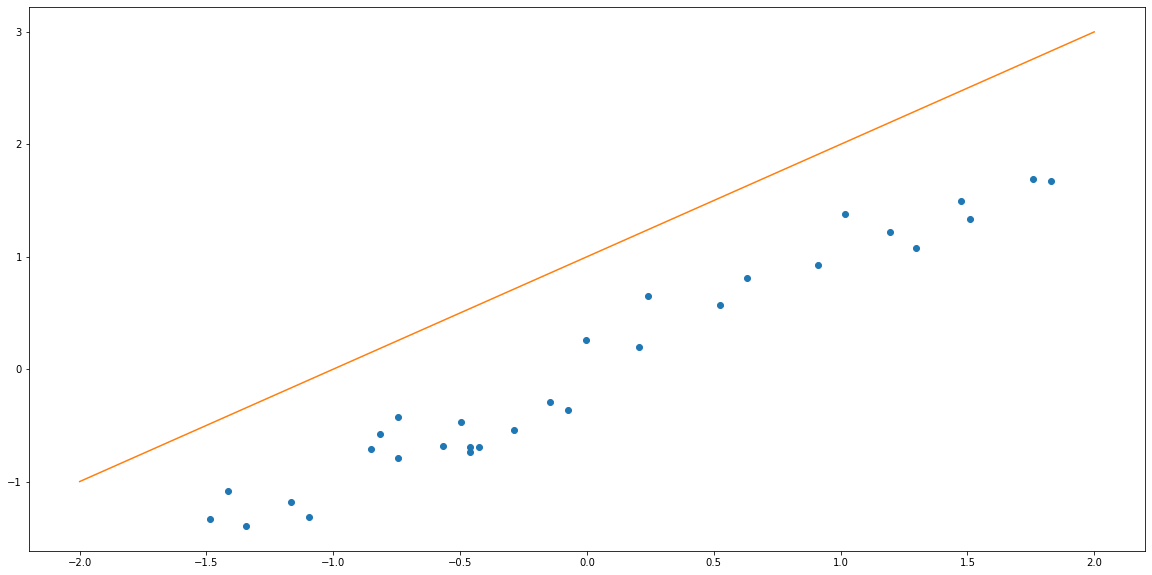

In [390]:
data = pd.read_csv('Salary_Data.csv')
years = data['YearsExperience']
salary = data['Salary']

avg_exp = years.mean()
dev_exp = years.std()

avg_salary = salary.mean()
dev_salary = salary.std()

years = torch.tensor([(e - avg_exp) / dev_exp for e in years])
salary = torch.tensor([(e - avg_salary) / dev_salary for e in salary])

plt.plot(years, salary, 'o')

a = torch.tensor([1.], requires_grad=True)
b = torch.tensor([1.], requires_grad=True)

x = np.linspace(-2, 2, 100)
plt.plot(x, b.data[0] * x + a.data[0])

In [391]:
optimizer = optim.SGD([a, b], lr=0.2)

loss_list = list()
grads_list = list()

for epoch in range(30):
    yhat = a + b * years
    error = salary - yhat
    loss = (error ** 2).mean()
    loss_list.append(loss.data)
    loss.backward()

    optimizer.step()
    grads_list.append(np.linalg.norm([a.grad, b.grad]))
    optimizer.zero_grad()

print(a, b)

tensor([2.0384e-07], requires_grad=True) tensor([0.9782], requires_grad=True)


C:\Users\dzahbarov\anaconda3\lib\site-packages\numpy\linalg\linalg.py:2514: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  x = asarray(x)
C:\Users\dzahbarov\anaconda3\lib\site-packages\numpy\linalg\linalg.py:2514: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = asarray(x)


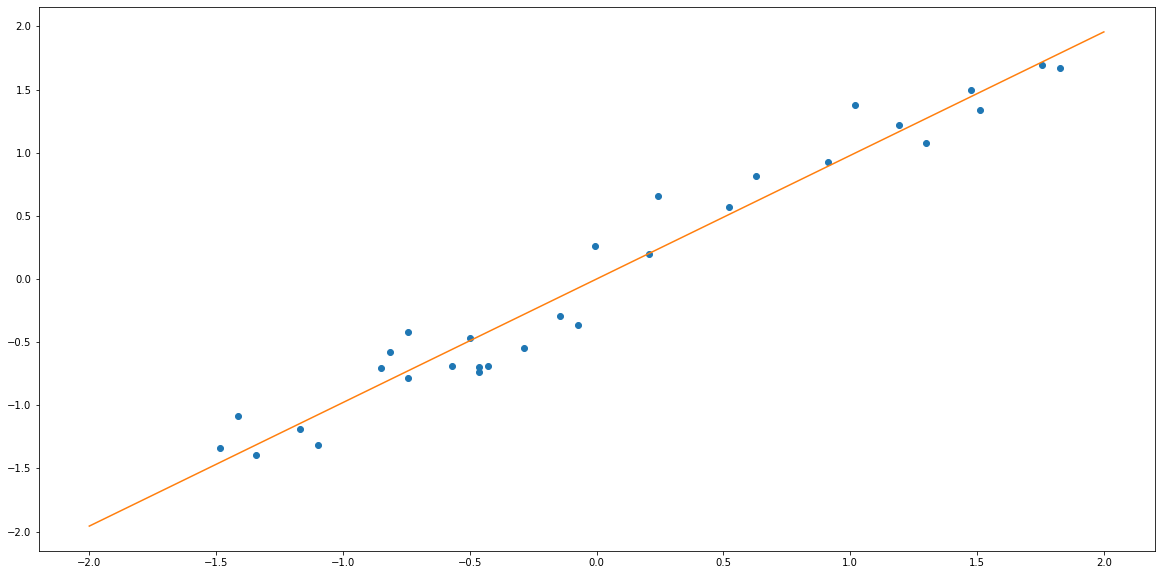

In [392]:
x = np.linspace(-2, 2, 100)
plt.plot(years, salary, 'o')
plt.plot(x, b.data[0] * x + a.data[0])

In [393]:
def f_normalized(x, idxs):
    res = 0
    for i in idxs:
        res += (x[0] * years[i] + x[1] - salary[i]) ** 2
    return res


def draw_normalized(points):
    res = points[-1]

    fig, (ax1, ax2) = plt.subplots(1, 2)
    x = np.linspace(-2, 2, 100)
    ax1.plot(years, salary, 'o')
    ax1.plot(x, res[0] * x + res[1])

    t = np.linspace(-1, 2.5, 100)
    X = np.meshgrid(t, t)
    ax2.contour(X[0], X[1], f_normalized(torch.tensor(X), range(0, 30)),
                levels=sorted([f_normalized(p, range(0, 30)) for p in points] + list(np.linspace(-1, 1, 100))))
    ax2.plot(points[:, 0], points[:, 1], 'o-', color='red')

In [394]:
def const_lr(n, start):
    return start


def exp_lr(n, start):
    k = 0.01
    return start * np.exp(-k * n)


def partial(f, i, x, idxs):
    h = 1e-3
    x[i] = x[i] + h
    right = f(x, idxs)
    x[i] = x[i] - 2 * h
    left = f(x, idxs)
    x[i] = x[i] + h

    return (right - left) / (2 * h)


def grad(f, x, idxs):
    return [partial(f, i, x, idxs) for i in range(len(x))]


def minibatch_grad(func, x, batch):
    idxs = random.sample(range(0, 30), batch)
    return grad(func, x, idxs)


def minibatch_sgd(f, lr, start, lr_strategy=exp_lr, epoch=20, batch=1):
    x = start
    points = np.zeros((epoch, 2))
    points[0] = x
    loss_list = list()
    for i in range(1, epoch):
        yhat = x[1] + x[0] * years
        error = salary - yhat
        loss = (error ** 2).mean()
        loss_list.append(loss.data)


        x = x - lr_strategy(i, lr) * np.array(minibatch_grad(f, x, batch))
        points[i] = x

    return np.array(points), np.array(loss_list)


def sgd(f, lr, start, lr_strategy=exp_lr, epoch=20):
    return minibatch_sgd(f, lr, start, lr_strategy=lr_strategy, epoch=epoch, batch=1)

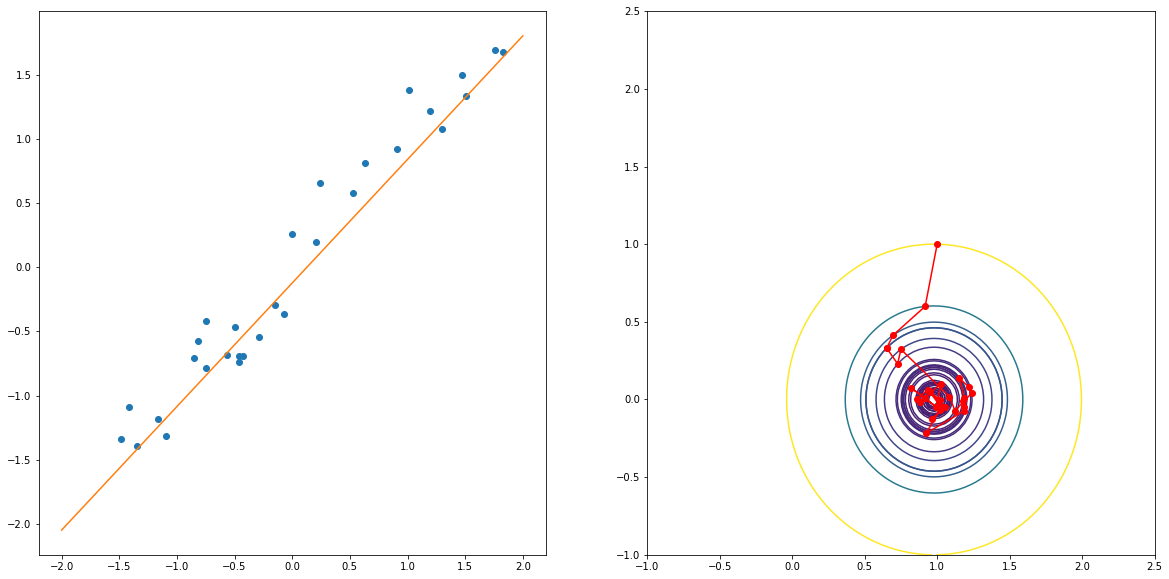

In [395]:
points, loss_list2 = sgd(f_normalized, 0.2, [1, 1], lr_strategy=exp_lr, epoch=30)
draw_normalized(points)

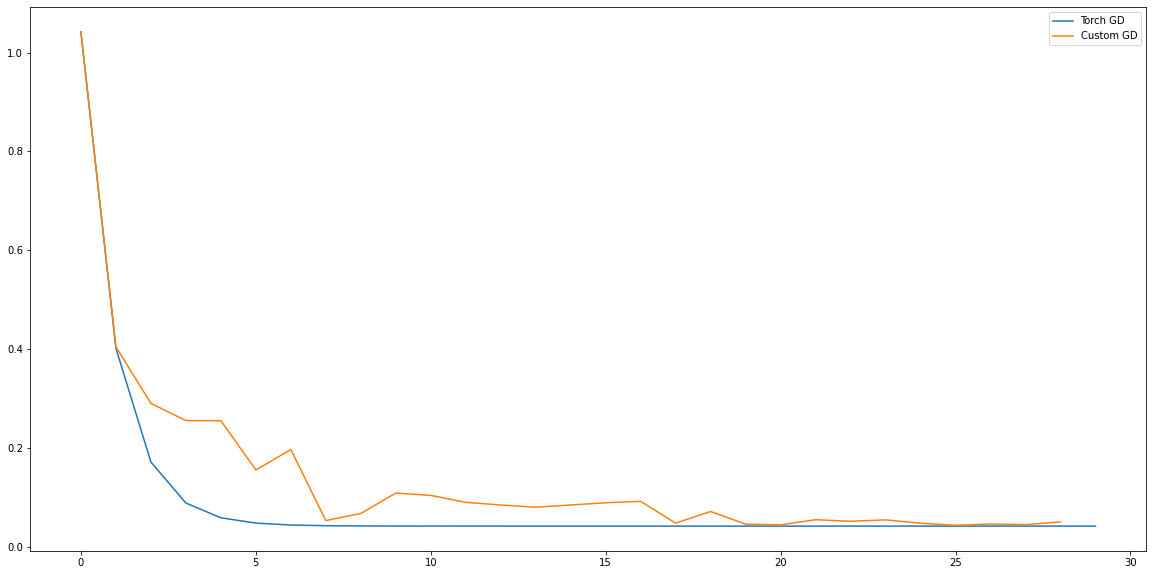

In [396]:
plt.plot(range(len(loss_list)), loss_list, label='Torch GD')
plt.plot(range(0, len(loss_list2)), loss_list2, label='Custom GD')
plt.legend()

In [397]:
a = torch.tensor([1.], requires_grad=True)
b = torch.tensor([1.], requires_grad=True)

optimizer = optim.Adam([a, b], lr=0.2)

loss_list = list()
grads_list = list()

for epoch in range(30):
    yhat = a + b * years
    error = salary - yhat
    loss = (error ** 2).mean()
    loss_list.append(loss.data)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

print(a, b)

tensor([0.0420], requires_grad=True) tensor([0.9506], requires_grad=True)


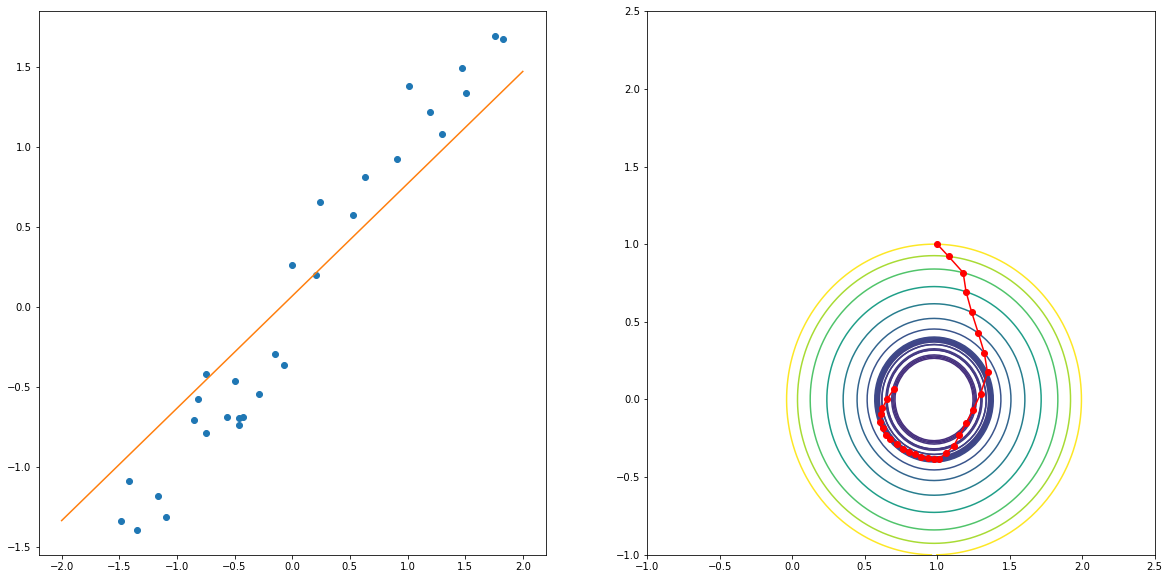

In [398]:
def adam(f, b1, b2, lr, start, lr_strategy=exp_lr, epoch=20, batch=1):
    x = start
    prev_grad = np.array([0, 0])
    prev_v = np.array([0, 0])
    points = list()
    loss_list3 = list()
    points.append(start)
    for i in range(1, epoch):
        yhat = x[1] + x[0] * years
        error = salary - yhat
        loss = (error ** 2).mean()
        loss_list3.append(loss.data)

        gr = np.array(minibatch_grad(f, x, batch))
        g = b1 * prev_grad + (1 - b1) * gr
        v = b2 * prev_v + (1 - b2) * np.power(gr, 2)
        x = x - lr_strategy(i, lr) * g / np.sqrt(v)
        prev_v = v
        prev_grad = g
        points.append(x)

    return np.array(points), np.array(loss_list3)


points, loss_list3 = adam(f_normalized, lr=0.025, b1=0.9, b2=0.999, lr_strategy=const_lr, start=[1, 1], epoch=30)
draw_normalized(points)

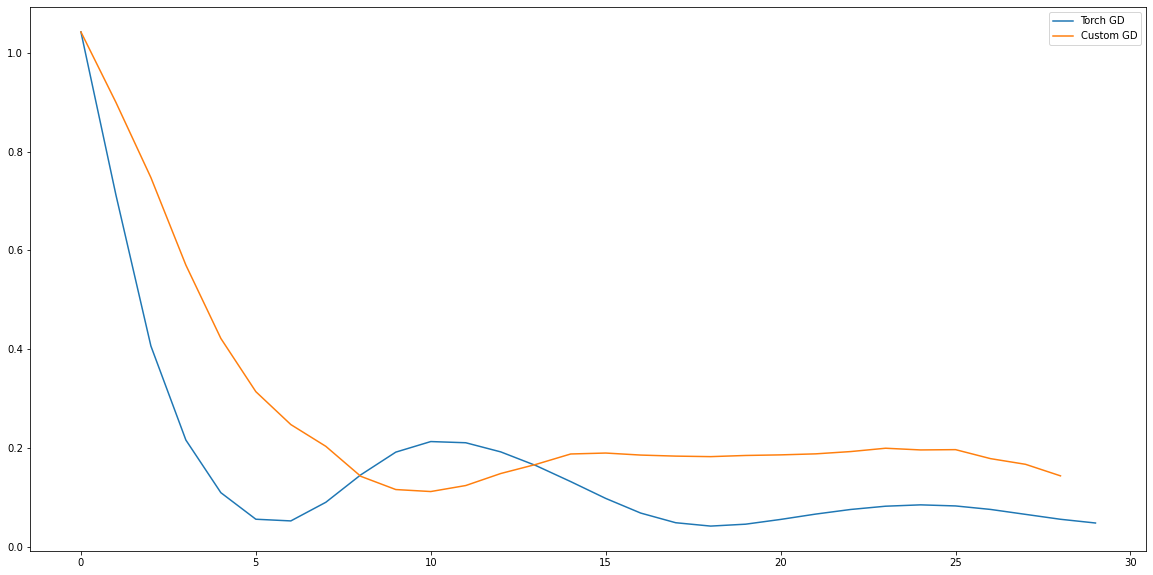

In [399]:
plt.plot(range(len(loss_list)), loss_list, label='Torch GD')
plt.plot(range(0, len(loss_list3)), loss_list3, label='Custom GD')
plt.legend()

## SciPy

In [400]:
func = lambda x, b1, b2, b3: np.e ** (-b1 * x) / (b2 + b3 * x)
minimizing_func = lambda b: np.sum((func(xs, b[0], b[1], b[2]) - ys) ** 2)

In [401]:
exp_beta_1 = 1
exp_beta_2 = 2
exp_beta_3 = 3

xs = np.linspace(0, 5, 100)
ys = func(xs, exp_beta_1, exp_beta_2, exp_beta_3)

In [402]:
start_point = [2, 4, 5]
loss_list = list()

def getLoss(x):
    return minimizing_func(x)

loss_list.append(getLoss(start_point))
res = opt.minimize(minimizing_func, start_point, method='BFGS', callback=lambda xk: loss_list.append(getLoss(xk)))

In [404]:
def gradient_func1(x):
    return np.array(minibatch_grad(minimizing_func, x))

def partial(f, i, x):
    h = 1e-7
    x[i] = x[i] + h
    right = f(x)
    x[i] = x[i] - 2 * h
    left = f(x)
    x[i] = x[i] + h

    return (right - left) / (2 * h)

def minibatch_grad(func, x, batch=30):
    return grad(func, x)

def grad(f, x):
    return np.array([partial(f, i, x) for i in range(len(x))])

def bfgs(f, grad_with_fixed_func, start, epoch):
    x = start

    points = list()
    grads = list()
    loss = list()

    points.append(x)

    I = np.eye(len(x))
    H = I

    gr = grad(f, x)
    loss.append(f(x))

    grads.append(np.linalg.norm(gr))
    for i in range(1, epoch):

        p = - H @ gr

        coef = opt.line_search(f, grad_with_fixed_func, x, p)[0]

        new_x = x + coef * p

        s = new_x - x
        x = new_x
        new_grad = grad(f, x)
        grads.append(np.linalg.norm(new_grad))
        loss.append(f(x))
        points.append(x)
        y = new_grad - gr

        if np.linalg.norm(grad(f, x)) < 1e-6:
            break

        gr = new_grad

        y = np.array([y])
        s = np.array([s])
        y = np.reshape(y, (len(x), 1))
        s = np.reshape(s, (len(x), 1))

        ro = 1.0 / (y.T @ s)
        H = (I - ro * s @ y.T) @ H @ (I - ro * y @ s.T) + ro * s @ s.T

    return [points, grads, loss]

In [405]:
bfgs_points, bfgs_grads, bfgs_loss = bfgs(minimizing_func, gradient_func1, start_point, epoch=1000)

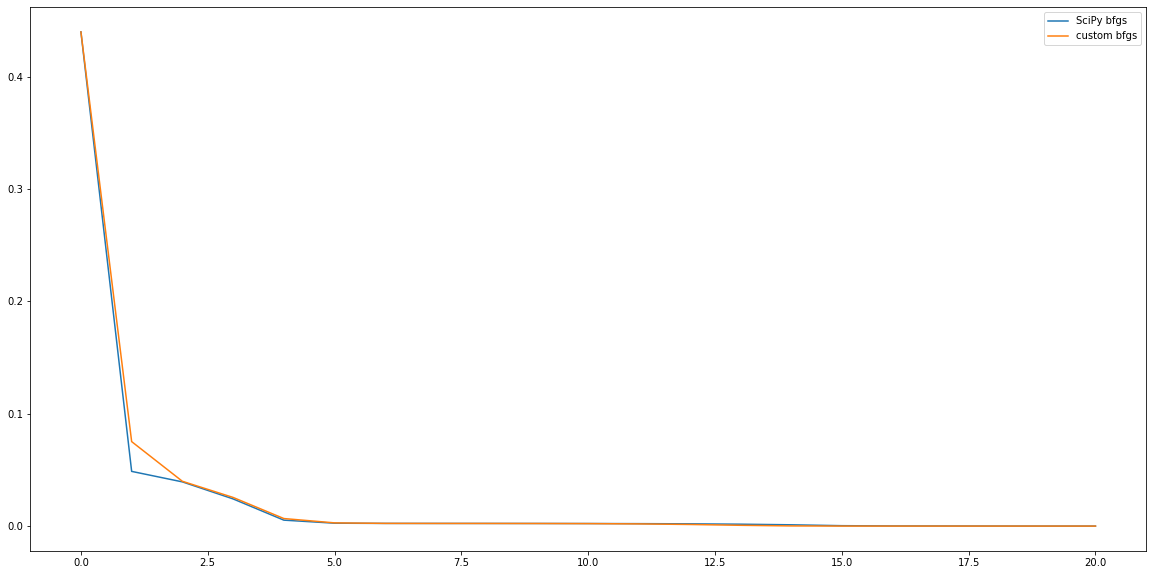

In [406]:
size = min(len(loss_list), len(bfgs_loss))
plt.plot(range(size), loss_list[:size], label='SciPy bfgs')
plt.plot(range(size), bfgs_loss[:size], label='custom bfgs')
plt.legend()